# Lecture 6 - models for sequences
In what has happened so far, we have focused on data that is sampled independently. That is, we have a data-point $x$, a label $y$ and we'd like to learn a function $f$ that maps $x$ to a prediction $\hat{y}$ or to a distribution over possible $y$ values.

However, so much data is a function of sequences. For example, 
- predicting the next frame of a video. Having the entire history of frames up until that point is pretty helpful.
- predicting the next word in some text. Having the entire history of words up until that point is pretty helpful.
- predicting the time evolution of a dynamical system. This one's a little less obvious but we'll go into it in  a bit. 

As a few examples, consider predicting the future time-evolution of a stock or
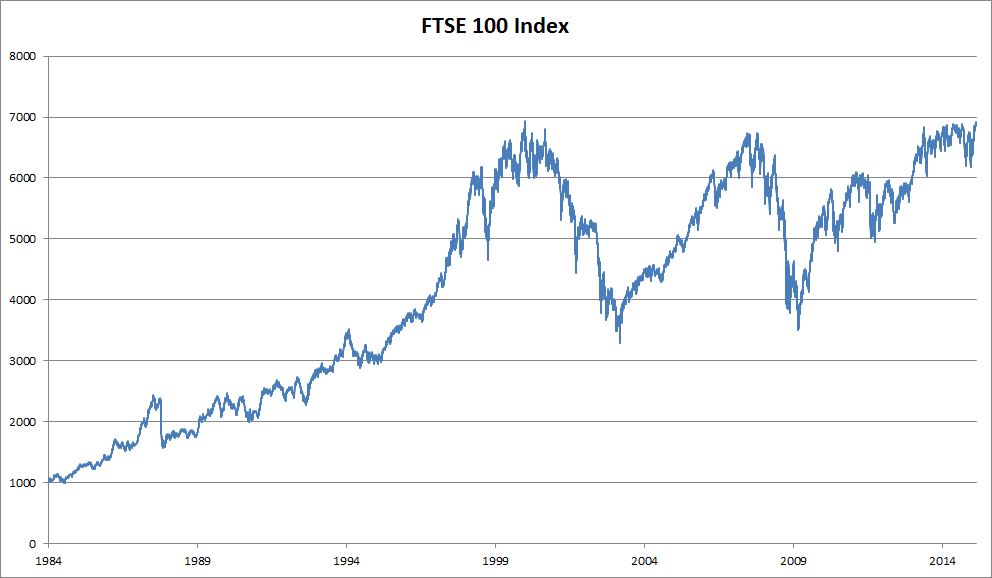

Rather than just a point prediction, we might like to predict the entire sequence and keep predicting. That is, we want to predict $P(x_{t+1}|x_1, x_2, ..., x_t)$ and then use that prediction to predict $P(x_{t+2}|x_1, x_2, ..., x_{t+1})$ and so on.

## Lets talk autoregression 
An *autoregressive model* is a model that depends on its own previous outputs. That is, the prediction at time $t$ depends on the prediction at time $t-1$ and may even depend on the predictions at $t-2$, $t-3$, etc. There are some obvious challenges here:
1. The number of potential inputs are going to grow with each step. 
2. The model is going to have to learn to remember things for a long time.
3. If we do a bad job at a prediction, that bad prediction is going to remain as a potential input to the model and make it worse. 

## Can't we do this with the architectures we've seen before?
In some sense, yes. For example, we could decide "well, we always have a fixed length sequence. Let's just make a really long vector that concatenates all the elements of the sequence and then use a feedforward neural network". This creates a feature vector that has a history and can use the information in that history for better prediction. It's a pretty good idea, it works fairly often, but it has downsides! Can you think of some?

### Some downsides
- The length of the input sequence is fixed. This means that if we train a model on sequences of 5 stacked inputs, we can't now suddenly use 6 stacked inputs.
- It's not set up for *autoregression*. That is, the model can predict the next element, but if you feed that prediction back into the model, it doesn't do a good job predicting the element after that. We'll see an instance of this in a second.

## Some of the challenges of using our existing models for sequnces

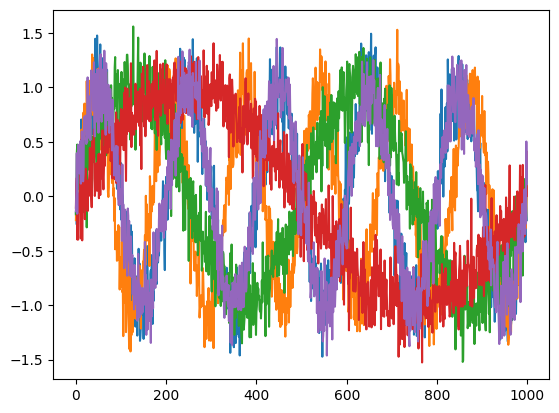

In [1]:
# Generate some time-series data that we will use for training RNNs
import torch
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
torch.manual_seed(1)

# Generate the time-series data
# We make a bunch of different time-series consisting
# of different frequencies of sine waves plus additive noise
num_series = 100
num_timepoints = 1000
time = torch.arange(0, num_timepoints).float()
data = torch.zeros(num_series, num_timepoints)
# (Note, you could and totally should vectorize this)
for i in range(num_series):
    freq = torch.randint(1, 10, (1,))
    data[i] = torch.sin(2 * torch.pi * freq * time / num_timepoints) + torch.randn(num_timepoints) * 0.2
    
# Plot the first 5 time-series
plt.figure()
for i in range(5):
    plt.plot(time, data[i])


In [2]:
# Okay, now lets see if we can successfully predict the next timepoint in the time-series for the first sine wave
# We look at doing a linear regression here for different time lags
class LinearRegressor(torch.nn.Module):
    def __init__(self, total_history=5):
        super(LinearRegressor, self).__init__()
        self.linear = torch.nn.Linear(total_history, 1)
        
    def forward(self, x):
        return self.linear(x)
    
# Okay, now lets turn this into data that's easy to iterate over
# using torch datasets and torch dataloaders
# This is a useful utility class that we will reuse
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, total_history, prediction_offset=0):
        self.data = data
        self.total_history = total_history
        self.prediction_offset = prediction_offset
        
    def __len__(self):
        # This tells pytorch how much data we have
        return len(self.data) - self.total_history - self.prediction_offset
    
    def __getitem__(self, idx):
        # This actually returns the data
        # Note that here we are constructing the features by stacking
        # a bunch of states together
        return self.data[idx:idx+self.total_history], self.data[idx+self.total_history + self.prediction_offset]

# Lets construct a train and a validation set for the first time-series
# what are the features? Well, they're some number of datapoints observed so far
# and the label is the next datapoint
# We're going to be lazy and just make the validation set the latter half of the data

def train_for_history(total_history=5, prediction_offset=1):
    train_split = 0.8
    num_train = int(num_timepoints * train_split)
    train_data = data[0, :num_train]
    val_data = data[0, num_train:]

    train_dataset = TimeSeriesDataset(train_data, total_history, prediction_offset)
    # val_dataset = TimeSeriesDataset(val_data, total_history, prediction_horizon)

    # Okay, now we can use an object called a torch dataloader to iterate over the data
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Okay, now lets train our model
    model = LinearRegressor(total_history)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    num_epochs = 30
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        avg_train_loss = 0
        for i, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            y_pred = model(x)
            l = loss(y_pred.squeeze(), y)
            l.backward()
            optimizer.step()
            avg_train_loss += l.item()
        train_losses.append(avg_train_loss)
        
        # avg_val_loss = 0
        # for i, (x, y) in enumerate(val_dataloader):
        #     y_pred = model(x)
        #     l = loss(y_pred.squeeze(), y)
        #     avg_val_loss += l.item()
        # val_losses.append(avg_val_loss)
        # print(f"Epoch {epoch} Train loss: {train_losses[-1]} Val loss: {val_losses[-1]}")

    # Now lets plot the training and validation losses
    plt.figure()
    plt.plot(train_losses, label='Train loss')
    # plt.plot(val_losses, label='Val loss')
    plt.legend()

    # Now lets plot our predictions
    model.eval()
    with torch.no_grad():
        predictions = []
        for i in range(train_data.shape[0] - total_history - prediction_offset):
            x = train_data[i:i+total_history]
            y = train_data[i+total_history + prediction_offset]
            y_pred = model(x)
            predictions.append(y_pred.item())
    
    plt.figure()
    plt.plot(train_data[total_history+prediction_offset:].numpy(), label='True')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    return model 


LinearRegressor(
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

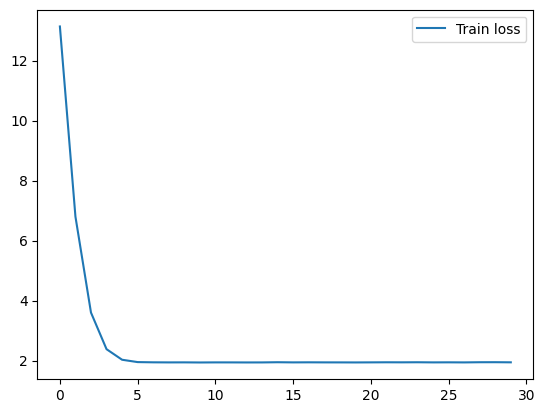

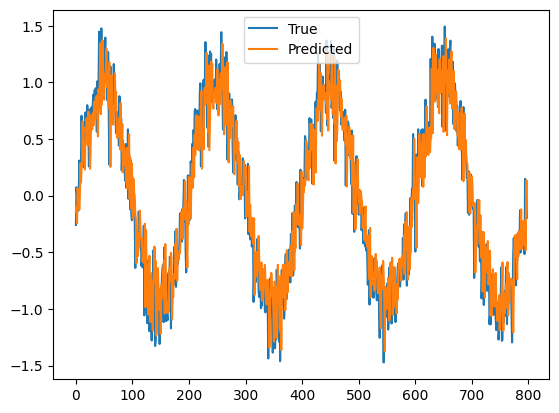

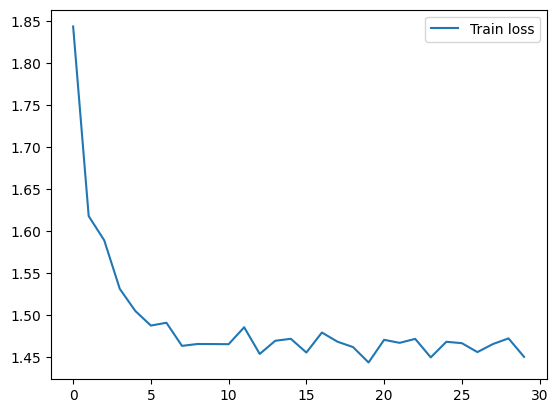

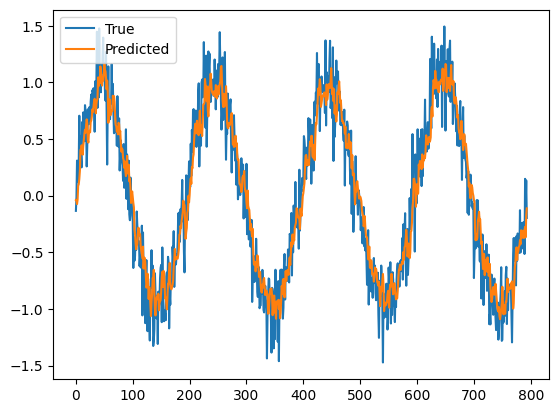

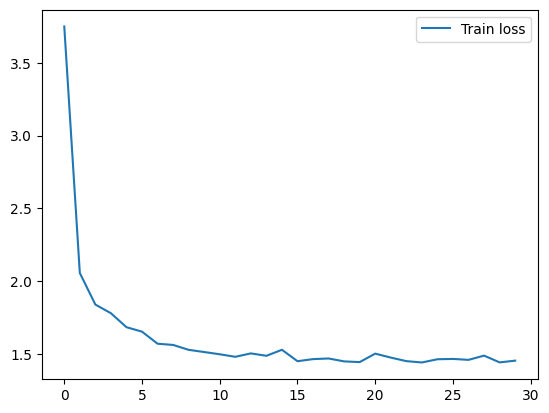

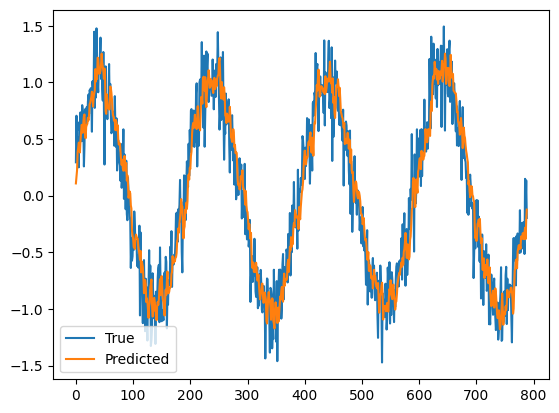

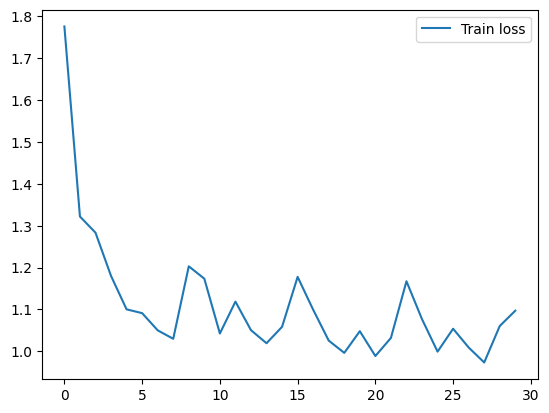

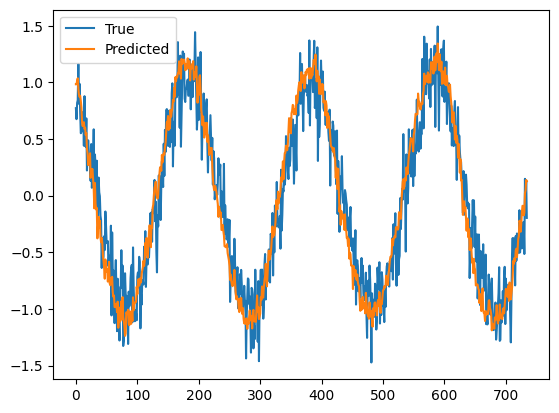

In [3]:
train_for_history(1)
train_for_history(5)
model = train_for_history(10)
train_for_history(64)

LinearRegressor(
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

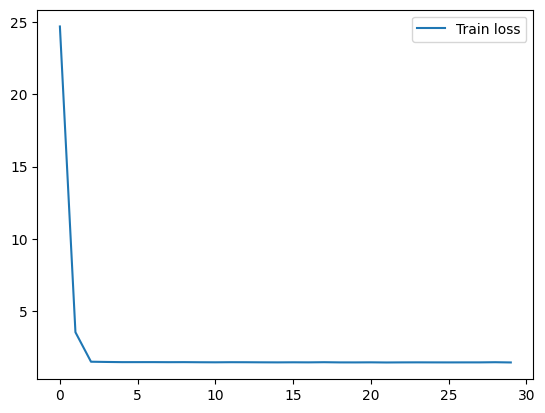

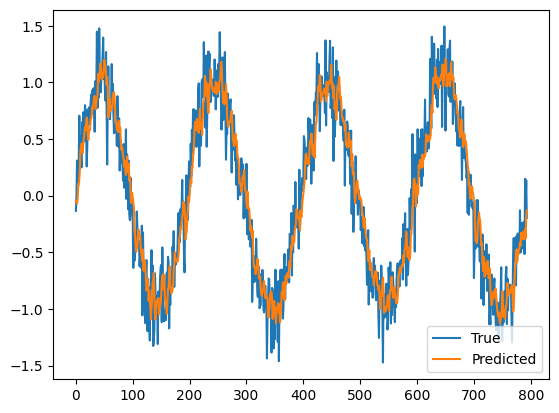

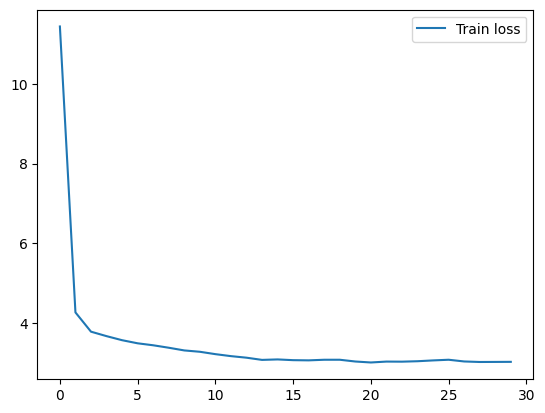

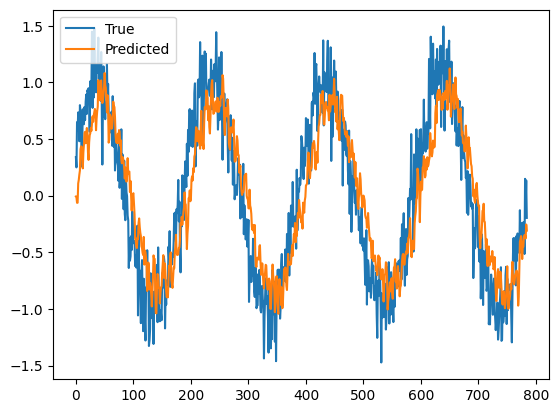

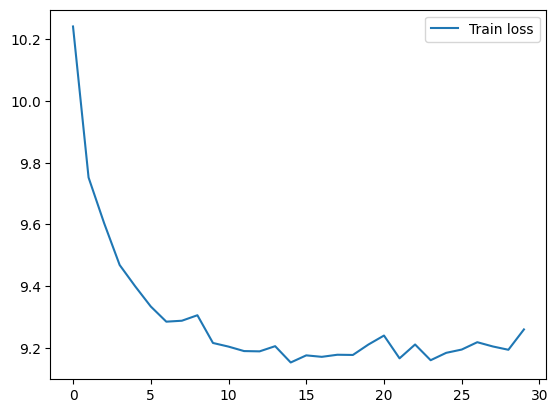

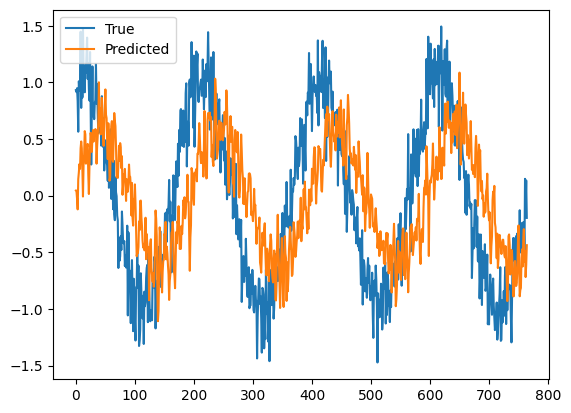

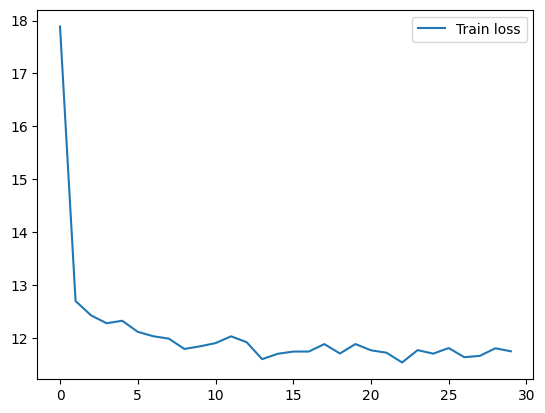

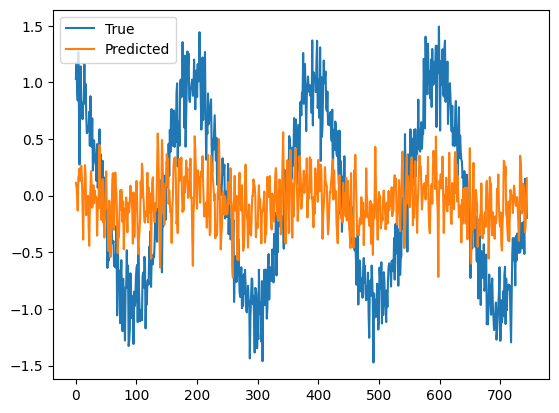

In [8]:
# now lets do the same thing for longer horizon predictions
train_for_history(5, 1)
train_for_history(5, 10)
train_for_history(5, 30)
train_for_history(5, 50)

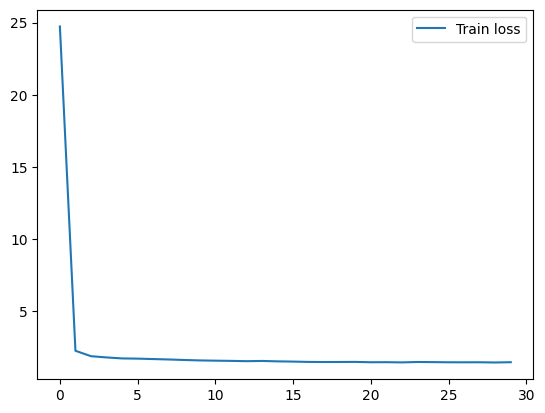

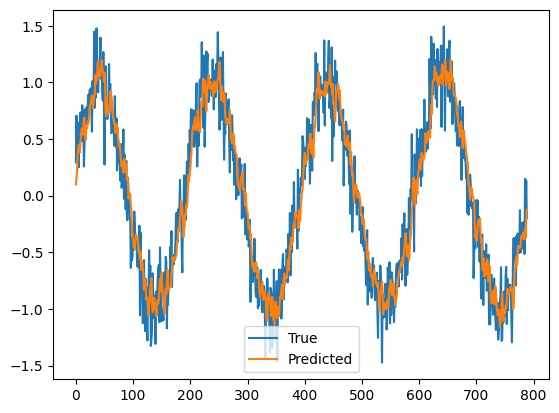

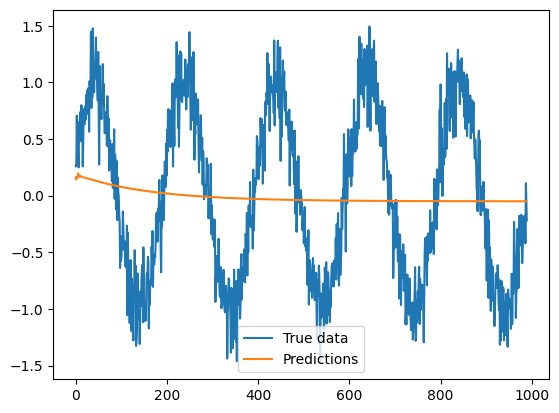

In [5]:
# At this point you might very well and reasonably say, why deep learning? Seems like we can fit this task pretty fine. 
# Now lets ask a slightly trickier question; what happens if we try to predict the next timepoint in the time-series and we sequentially keep using the previous prediction as the next input?

history_len = 10
model = train_for_history(history_len)
train_dataset = TimeSeriesDataset(data[0], history_len)
# Lets grab the first datapoint and iterate from there
x, y = train_dataset[0]
predictions = []
for i in range(1, num_timepoints - history_len):
    x = torch.cat((x[1:], y.unsqueeze(0)))
    y = model(x).squeeze()
    predictions.append(y.item())

plt.figure()
plt.plot(data[0, history_len:], label='True data')
plt.plot(predictions, label='Predictions')
plt.legend()


## Accumulating error
So what's wrong? The issue is that we are trying to chain together a series of predictions that are accurate for each individual point but always with a little bit of error. When we chain these together, the error compounds and we end up with a prediction that is very far from the true value. Imagine that at the first step we have some error $\epsilon_1$. Lets denote our time series as $x$ and use $x_t$ to denote the t-th element. Lets call the stacked feature we have been making $f_t$ to represent the t-th feature and use $\phi_{t,i}$ to denote the i-th element of the t-th feature. Finally, we will call our model $f$ as in $$y = f(\phi)$$ Then our first feature is $$\phi_0 = \left[x_0, x_1, x_2, \dots, x_T\right]$$ where $T$ is the time window that we are using for features. Calling our i-th prediction as $y_i$ our next feature will then be $$f_1 = \left[x_1, x_2, \dots, x_T, y_0\right]$$ where $y_0$ is our prediction of $x_{T+1}$. The problem is that $y_0$ is not the same as $x_{T+1}$ and so we have some error $\epsilon_1 = y_0 - x_{T+1}$. This error will compound as we make more predictions. Our next prediction will be $y_1 = f(\phi_1)$ and our next feature will be $\phi_2 = {x_2, \dots, x_T, y_0, y_1}$ where $y_1$ is our prediction of $x_{T+2}$. The error in this prediction will be $\epsilon_2 = y_1 - x_{T+2}$. This error will compound with the previous error and so on.

So, gradually, due to accumulating error, our features look less and less like the data and so our model will perform worse and worse. It simply has not seen features that look like this at all. 

# Latent autoregressive models
For this lecture, we're mostly going to talk about latent autoregressive models. These are models that are autoregressive, but they have a latent variable that helps them to remember the past. This latent variable is a hidden state that is updated at each time step and is used to make the next prediction.

So, we treat the probability of the next token $$P(x_{t+1}|x_1, x_2, \dots, x_t)$$ as a function of the hidden state $h_t$ and the current token $x_t$. That is, we have $$P(x_{t+1}|x_1, x_2, \dots, x_t) = P(x_{t+1}|h_t, x_t)$$
where $h_t$ is a hidden state that is sequentially being update at each time-step $$h_{t+1} = f(h_t, x_t)$$

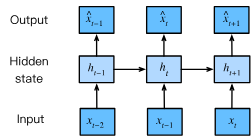

(Source: "Dive into Deep Learning" by Aston Zhang, Zachary C. Lipton, Mu Li, and Alexander J. Smola)

We can view this, from two perspectives, as a model that is recursively looping onto itself or as the unrolled variant, which generates a giant long feedforward graph with an identical weight matrix at every step.

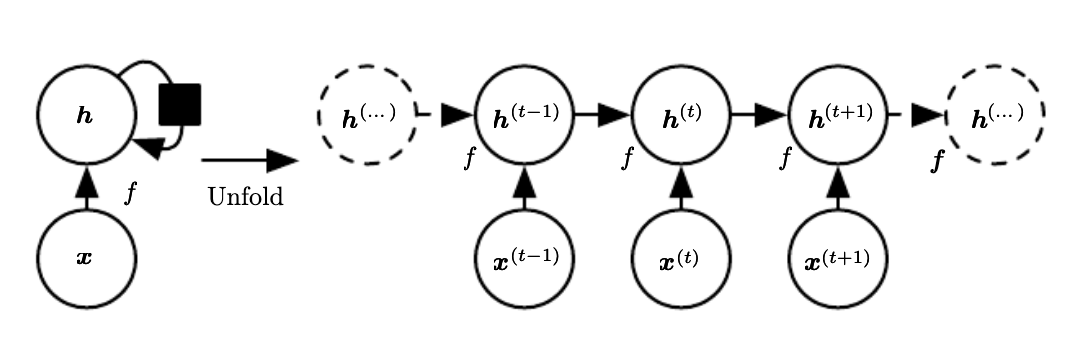

(Source: "Deep Learning Book" by Goodfellow, Bengio, and Courville)

But of course, what we care about is prediction, so we can use the hidden state to predict the next token $$P(x_{t+1}|h_t, x_t) = g(h_t, x_t)$$. This graph subsequently looks like this

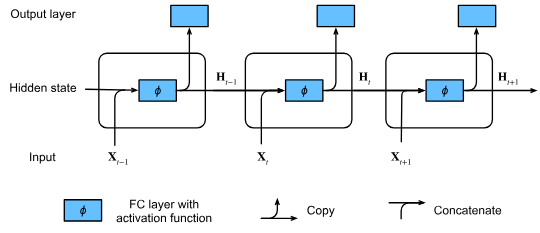

(Source: "Dive into Deep Learning" by Aston Zhang, Zachary C. Lipton, Mu Li, and Alexander J. Smola)

So what does this look like for an actual task we might care about? For example, for predicting the next character in a sentence it might look like
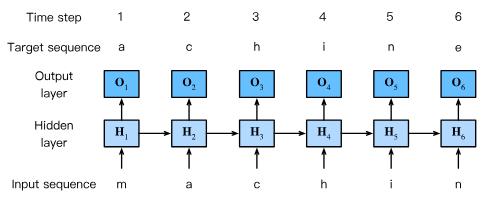

(Source: "Dive into Deep Learning" by Aston Zhang, Zachary C. Lipton, Mu Li, and Alexander J. Smola)
Here we started with the character "m" and asked the network to predict the next character. It predicted "a". Then given "a" as an input and the hidden state, it predicted "c". And so on. This output is often denoted as $$o_t$$. 

For each time-step, we can compare the prediction we did make with the actual value and use that to form a loss. This loss can be used to update the weights of the model. From this perspective, the whole graph looks like this

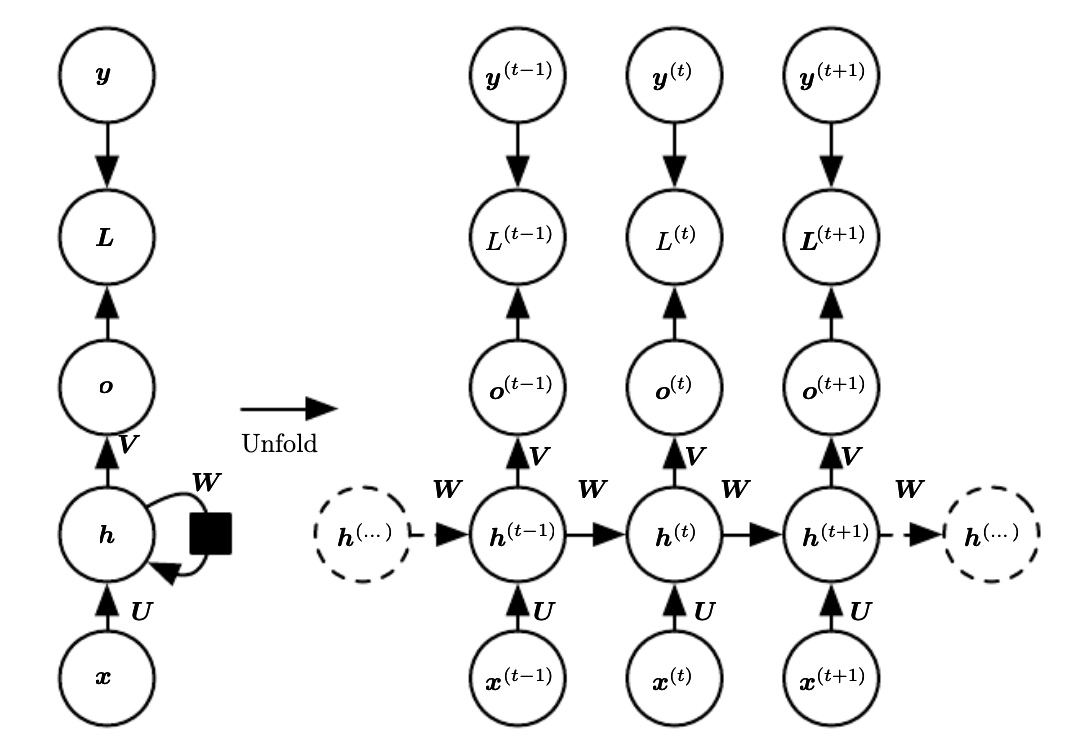

(Source: "Deep Learning Book" by Goodfellow, Bengio, and Courville)

where here the function $f$ used to update the hidden state is just a multiplication by a weight matrix.

Now, as something that's entirely abstract it's a little unclear, so lets actually build a network to do this type of prediction. 

## Starting with a simple example, redoing the sine wave

Epoch 1/5000, Loss: 10.137367
Epoch 2/5000, Loss: 10.154991
Epoch 3/5000, Loss: 10.461684
Epoch 4/5000, Loss: 10.569552
Epoch 5/5000, Loss: 10.667844
Epoch 6/5000, Loss: 10.714854
Epoch 7/5000, Loss: 10.201641
Epoch 8/5000, Loss: 10.100657
Epoch 9/5000, Loss: 10.895442
Epoch 10/5000, Loss: 10.202614
Epoch 11/5000, Loss: 10.618540
Epoch 12/5000, Loss: 10.277075
Epoch 13/5000, Loss: 11.135680
Epoch 14/5000, Loss: 10.183113
Epoch 15/5000, Loss: 9.747205
Epoch 16/5000, Loss: 9.960834
Epoch 17/5000, Loss: 9.946790
Epoch 18/5000, Loss: 10.084911
Epoch 19/5000, Loss: 9.969299
Epoch 20/5000, Loss: 10.129540
Epoch 21/5000, Loss: 10.288668
Epoch 22/5000, Loss: 9.891276
Epoch 23/5000, Loss: 9.608796
Epoch 24/5000, Loss: 10.120685
Epoch 25/5000, Loss: 9.663534
Epoch 26/5000, Loss: 10.006794
Epoch 27/5000, Loss: 9.341434
Epoch 28/5000, Loss: 9.817105
Epoch 29/5000, Loss: 10.471540
Epoch 30/5000, Loss: 10.235643
Epoch 31/5000, Loss: 9.705959
Epoch 32/5000, Loss: 9.627074
Epoch 33/5000, Loss: 10.0233

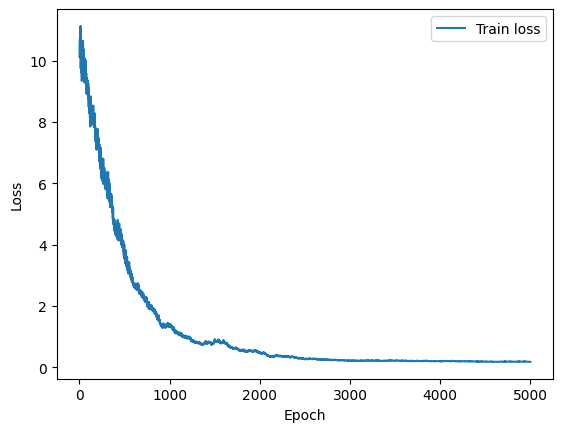

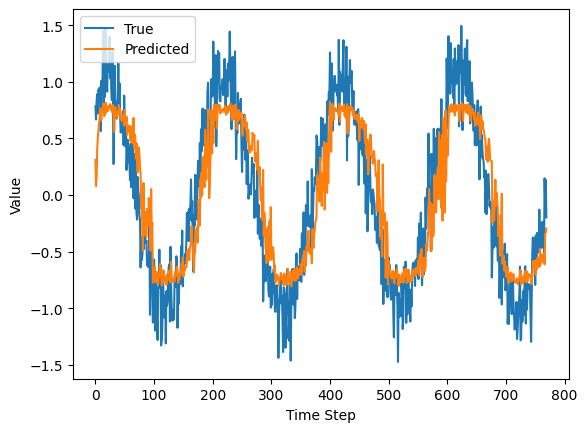

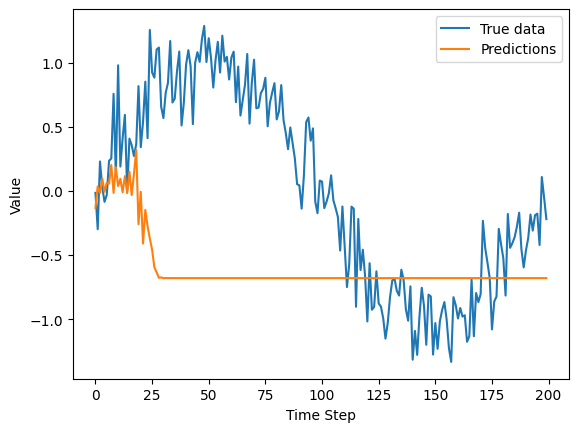

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Device configuration. For this class I'll use the GPU on my machine
# to make things faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Simple RNN model
class SimpleRNN(nn.Module):
    def __init__(self, hidden_size=10):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.W_xh = nn.Parameter(torch.randn(1, hidden_size))
        self.W_hy = nn.Parameter(torch.randn(hidden_size, 1))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        self.b_y = nn.Parameter(torch.zeros(1))
        
    def forward(self, xi, h=None):
        # input is (batch size, feature dimension)
        batch_size = xi.size(0)
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size).to(device)
        h = torch.tanh(torch.matmul(h, self.W_hh) + torch.matmul(xi, self.W_xh) + self.b_h)
        y_pred = torch.matmul(h, self.W_hy) + self.b_y
        return y_pred, h

# Multi-step prediction dataset
class MultiStepPredictionDataset(Dataset):
    def __init__(self, data, total_history, prediction_horizon=1):
        self.data = data
        # how long of an input of an input we have
        self.total_history = total_history
        # the offset that we are predicting on. So for example, prediction_horizon=0 means we are predicting the next timepoint
        self.prediction_horizon = prediction_horizon
                
    def __len__(self):
        return len(self.data) - self.total_history - self.prediction_horizon + 1
            
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.total_history]
        y = self.data[idx+self.total_history:idx+self.total_history + self.prediction_horizon]
        return x, y

# Parameters
history_len = 30
prediction_horizon = 10
train_split = 0.8
max_grad_norm = 1
num_train = int(num_timepoints * train_split)
train_data = data[0, :num_train]
val_data = data[0, num_train:]

# Datasets and DataLoaders
train_dataset = MultiStepPredictionDataset(train_data, history_len, prediction_horizon=prediction_horizon)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

# Model, loss, optimizer
model = SimpleRNN(hidden_size=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 5000
train_losses = []

import random

teacher_forcing_ratio = 0.5  # You can adjust this value

for epoch in range(num_epochs):
    model.train()
    avg_train_loss = 0
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        h = None

        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Process the history to update h
        for t in range(history_len):
            xi = x_batch[:, t].unsqueeze(1)  # Shape: [batch_size, 1]
            _, h = model(xi, h)

        curr_loss = 0
        xi = x_batch[:, -1].unsqueeze(1)
        for t in range(prediction_horizon):
            y_pred, h = model(xi, h)
            y_true = y_batch[:, t]
            curr_loss += criterion(y_pred.squeeze(), y_true)

            # Decide whether to use teacher forcing
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

            if use_teacher_forcing:
                # Use ground truth as the next input
                xi = y_true.unsqueeze(1)
            else:
                # Use model's own prediction as the next input
                xi = y_pred.detach()  # Detach to prevent backpropagation through predictions

        # Average the loss over the prediction horizon
        curr_loss /= prediction_horizon
        curr_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        avg_train_loss += curr_loss.item()
        
        # Now gradually decrease the teacher forcing ratio
        teacher_forcing_ratio *= 0.999
    avg_train_loss /= len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')

# Plotting the training loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate the training predictions
with torch.no_grad():
    predictions = []
    h = None
    x_seq = train_data[:history_len].to(device)
    # Process the history to update h
    for xi in x_seq:
        xi = xi.unsqueeze(0).unsqueeze(1)
        _, h = model(xi, h)

    xi = x_seq[-1].unsqueeze(0).unsqueeze(1)  # Last value in history
    for i in range(history_len, len(train_data)):
        y_pred, h = model(xi, h)
        predictions.append(y_pred.item())
        xi = train_data[i].unsqueeze(0).unsqueeze(1).to(device)  # Use true data for next input


# Plotting the training predictions
plt.figure()
plt.plot(train_data[history_len:].cpu().numpy(), label='True')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Autoregressive prediction on validation data
with torch.no_grad():
    predictions = []
    h = None
    # Use last history_len points from train_data to initialize h
    x_seq = train_data[-history_len:].to(device)
    for xi in x_seq:
        xi = xi.unsqueeze(0).unsqueeze(1)
        _, h = model(xi, h)

    xi = x_seq[-1].unsqueeze(0).unsqueeze(1)  # Last value in history
    for i in range(len(val_data)):
        y_pred, h = model(xi, h)
        predictions.append(y_pred.item())
        xi = y_pred  # Use model prediction as next input

# Plotting the validation predictions
plt.figure()
plt.plot(val_data.cpu().numpy(), label='True data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


## Lets try fancier architectures
The Vanilla RNN was up to snuff for prediction, but not autoregressive prediction! Lets try the LSTM that we discussed previously. I'll show you a from scratch implementation and then I'll also show you how to just use the default Torch version.

Epoch 1/5000, Loss: 1.488727
Epoch 2/5000, Loss: 1.509457
Epoch 3/5000, Loss: 1.348970
Epoch 4/5000, Loss: 1.316724
Epoch 5/5000, Loss: 1.294429
Epoch 6/5000, Loss: 1.266344
Epoch 7/5000, Loss: 1.261650
Epoch 8/5000, Loss: 1.392881
Epoch 9/5000, Loss: 1.074965
Epoch 10/5000, Loss: 1.083557
Epoch 11/5000, Loss: 1.021419
Epoch 12/5000, Loss: 0.989405
Epoch 13/5000, Loss: 1.024515
Epoch 14/5000, Loss: 0.965345
Epoch 15/5000, Loss: 0.937752
Epoch 16/5000, Loss: 0.852736
Epoch 17/5000, Loss: 0.948666
Epoch 18/5000, Loss: 0.821321
Epoch 19/5000, Loss: 0.756511
Epoch 20/5000, Loss: 0.774151
Epoch 21/5000, Loss: 0.777421
Epoch 22/5000, Loss: 0.706453
Epoch 23/5000, Loss: 0.681344
Epoch 24/5000, Loss: 0.733670
Epoch 25/5000, Loss: 0.686354
Epoch 26/5000, Loss: 0.706680
Epoch 27/5000, Loss: 0.659093
Epoch 28/5000, Loss: 0.706728
Epoch 29/5000, Loss: 0.655826
Epoch 30/5000, Loss: 0.621814
Epoch 31/5000, Loss: 0.594571
Epoch 32/5000, Loss: 0.633487
Epoch 33/5000, Loss: 0.621503
Epoch 34/5000, Loss

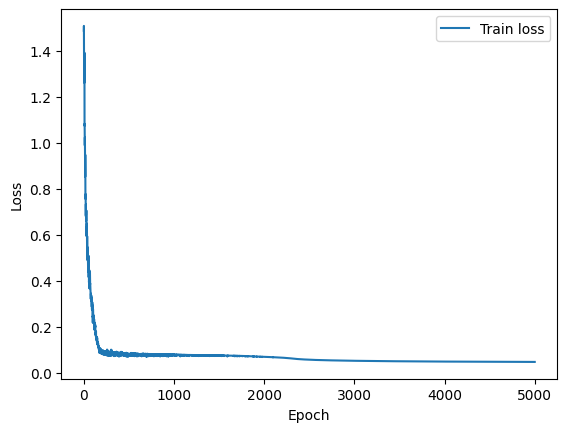

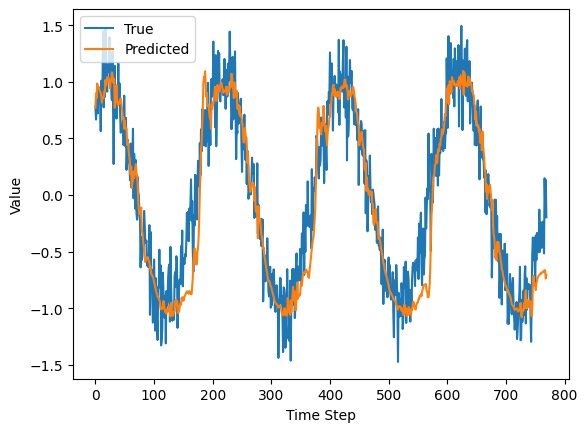

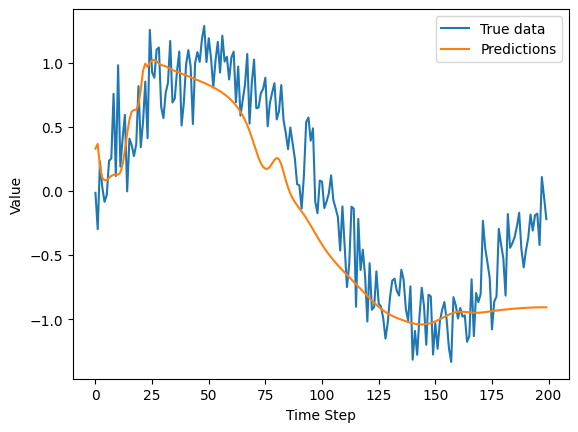

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Device configuration. For this class I'll use the GPU on my machine
# to make things faster
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# LSTM model from scratch, not using Torch layer
class ScratchLSTM(nn.Module):
    def __init__(self, hidden_size=10):
        super(ScratchLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.W_f = nn.Parameter(torch.randn(1, hidden_size + 1, hidden_size))
        self.W_i = nn.Parameter(torch.randn(1, hidden_size + 1, hidden_size))
        self.W_o = nn.Parameter(torch.randn(1, hidden_size + 1, hidden_size))
        self.W_c = nn.Parameter(torch.randn(1, hidden_size + 1, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))
        self.W_hy = nn.Parameter(torch.randn(hidden_size, 1))
        self.b_y = nn.Parameter(torch.zeros(1))
    
    def forward(self, xi, h=None, c=None):
        batch_size = xi.size(0)
        if h is None:
            h = torch.zeros(batch_size, self.hidden_size).to(device)
        if c is None:
            c = torch.zeros(batch_size, self.hidden_size).to(device)
        combined = torch.cat((xi, h), dim=1)
        f = torch.sigmoid(torch.matmul(combined, self.W_f.squeeze()) + self.b_f)
        i = torch.sigmoid(torch.matmul(combined, self.W_i.squeeze()) + self.b_i)
        o = torch.sigmoid(torch.matmul(combined, self.W_o.squeeze()) + self.b_o)
        c_hat = torch.tanh(torch.matmul(combined, self.W_c.squeeze()) + self.b_c)
        c = f * c + i * c_hat
        h = o * torch.tanh(c)
        y_pred = torch.matmul(h, self.W_hy) + self.b_y
        return y_pred, h, c
    
# This is the simplified torch module and what you'd probably actually use
class TorchLSTM(nn.Module):
    def __init__(self, hidden_size=10):
        super(TorchLSTM, self).__init__()
        # This lets us use the LSTM layer in PyTorch
        # batch_first means that the input and output tensors are provided as (batch, seq, feature)
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x, h=None, c=None):
        out, (h, c) = self.lstm(x.unsqueeze(-1), (h.unsqueeze(0), c.unsqueeze(0)))
        y_pred = self.linear(out.squeeze())
        return y_pred, h.squeeze(0), c.squeeze(0)

# Parameters
history_len = 30
prediction_horizon = 10
train_split = 0.8
max_grad_norm = 1
num_train = int(num_timepoints * train_split)
train_data = data[0, :num_train]
val_data = data[0, num_train:]

# Datasets and DataLoaders
train_dataset = MultiStepPredictionDataset(train_data, history_len, prediction_horizon=prediction_horizon)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False)

# Model, loss, optimizer
model = ScratchLSTM(hidden_size=10).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 5000
train_losses = []

import random

teacher_forcing_ratio = 0.5  # You can adjust this value

for epoch in range(num_epochs):
    model.train()
    avg_train_loss = 0
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        h = None
        c = None

        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Process the history to update h
        for t in range(history_len):
            xi = x_batch[:, t].unsqueeze(1)  # Shape: [batch_size, 1]
            _, h, c = model(xi, h, c)

        curr_loss = 0
        xi = x_batch[:, -1].unsqueeze(1)
        for t in range(prediction_horizon):
            y_pred, h, c = model(xi, h, c)
            y_true = y_batch[:, t]
            curr_loss += criterion(y_pred.squeeze(), y_true)

            # Decide whether to use teacher forcing
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

            if use_teacher_forcing:
                # Use ground truth as the next input
                xi = y_true.unsqueeze(1)
            else:
                # Use model's own prediction as the next input
                xi = y_pred.detach()  # Detach to prevent backpropagation through predictions

        # Average the loss over the prediction horizon
        curr_loss /= prediction_horizon
        curr_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        avg_train_loss += curr_loss.item()
        
        # Now gradually decrease the teacher forcing ratio
        teacher_forcing_ratio *= 0.999
    avg_train_loss /= len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')

# Plotting the training loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate the training predictions
with torch.no_grad():
    predictions = []
    h = None
    c = None
    x_seq = train_data[:history_len].to(device)
    # Process the history to update h
    for xi in x_seq:
        xi = xi.unsqueeze(0).unsqueeze(1)
        _, h, c = model(xi, h, c)

    xi = x_seq[-1].unsqueeze(0).unsqueeze(1)  # Last value in history
    for i in range(history_len, len(train_data)):
        y_pred, h, c = model(xi, h, c)
        predictions.append(y_pred.item())
        xi = train_data[i].unsqueeze(0).unsqueeze(1).to(device)  # Use true data for next input


# Plotting the training predictions
plt.figure()
plt.plot(train_data[history_len:].cpu().numpy(), label='True')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Autoregressive prediction on validation data
with torch.no_grad():
    predictions = []
    h = None
    c = None
    # Use last history_len points from train_data to initialize h
    x_seq = train_data[-history_len:].to(device)
    for xi in x_seq:
        xi = xi.unsqueeze(0).unsqueeze(1)
        _, h, c = model(xi, h, c)

    xi = x_seq[-1].unsqueeze(0).unsqueeze(1)  # Last value in history
    for i in range(len(val_data)):
        y_pred, h, c = model(xi, h, c)
        predictions.append(y_pred.item())
        xi = y_pred  # Use model prediction as next input

# Plotting the validation predictions
plt.figure()
plt.plot(val_data.cpu().numpy(), label='True data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


It's not great, but it's our first partial success!! Autoregressive prediction is hard ya'll.

## Now lets do some character prediction because it's fun!

In [6]:
# We need to load up some character data. A common one is the text of Shakespeare's plays
import urllib.request
url = 'https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt'
response = urllib.request.urlopen(url)
data = response.read()
text = data.decode('utf-8')
print(text[:1000])

# we don't want to work with too much text so lets do
text = text[:100000]


This is the 100th Etext file presented by Project Gutenberg, and
is presented in cooperation with World Library, Inc., from their
Library of the Future and Shakespeare CDROMS.  Project Gutenberg
often releases Etexts that are NOT placed in the Public Domain!!

Shakespeare

*This Etext has certain copyright implications you should read!*

<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM
SHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS
PROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE
WITH PERMISSION.  ELECTRONIC AND MACHINE READABLE COPIES MAY BE
DISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS
PERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED
COMMERCIALLY.  PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY
SERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP.>>

*Project Gutenberg is proud to cooperate with The World Library*
in the presentation of The Complete Works of William Shakespeare
for your reading for educatio

Epoch 1/10, Loss: 3.077922
Epoch 2/10, Loss: 2.559729
Epoch 3/10, Loss: 2.339689
Epoch 4/10, Loss: 2.203805
Epoch 5/10, Loss: 2.096676
Epoch 6/10, Loss: 2.007239
Epoch 7/10, Loss: 1.927128
Epoch 8/10, Loss: 1.864223
Epoch 9/10, Loss: 1.797730
Epoch 10/10, Loss: 1.746252


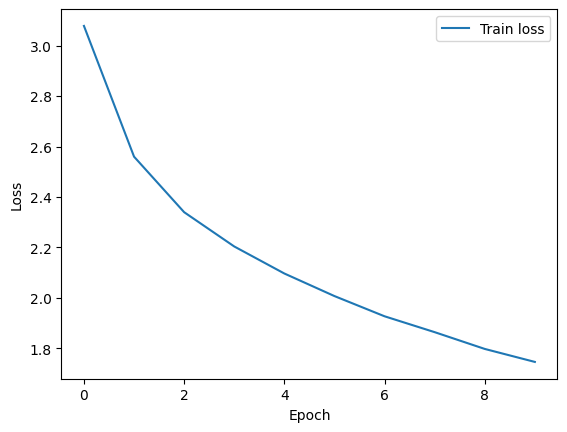

In [7]:
# Okay! Lets turn this into a dataset that we can use for training
# We will use a sequence length of 100 characters

class ShakespeareDataset(Dataset):
    def __init__(self, text, seq_len=100):
        self.text = text
        self.seq_len = seq_len
        # we need to convert the text into a set of unique characters
        # we also need to create a mapping from characters to indices
        # that we will eventually convert into one-hot vectors
        self.chars = sorted(list(set(text)))
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        
    def __len__(self):
        return len(self.text) - self.seq_len
    
    def __getitem__(self, idx):
        x_str = self.text[idx:idx+self.seq_len]
        y_str = self.text[idx+1:idx+self.seq_len+1]
        x = torch.tensor([self.char_to_idx[ch] for ch in x_str])
        y = torch.tensor([self.char_to_idx[ch] for ch in y_str])
        # One-hot encode x only
        x = torch.nn.functional.one_hot(x, num_classes=len(self.chars)).float()
        # Do not one-hot encode y
        return x, y

# Lets create a dataset and dataloader
dataset = ShakespeareDataset(text)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)

# We also need a model that actually outputs predictions of the correct shape
# and has a softmax to convert the output into probabilities
# Note that the inputs are one-hot so they're the length of the number of characters
class TorchLSTM(nn.Module):
    def __init__(self, hidden_size=512):
        super(TorchLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=len(dataset.chars), hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, len(dataset.chars))
        
    def forward(self, x, h=None, c=None):
        if h is None or c is None:
            # Initialize h and c with the correct shape: (num_layers, batch_size, hidden_size)
            h = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
            c = torch.zeros(1, x.size(0), self.lstm.hidden_size).to(x.device)
        out, (h, c) = self.lstm(x, (h, c))
        # convert the output into the right shape using a linear layer
        y_pred = self.linear(out)
        return y_pred

# create our model
model = TorchLSTM(hidden_size=512).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10
train_losses = []

for i in range(num_epochs):
    model.train()
    avg_train_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        # y_pred shape: (batch_size, seq_len, num_classes)
        # y shape: (batch_size, seq_len)
        loss = criterion(y_pred.permute(0, 2, 1), y)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
    avg_train_loss /= len(dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {i+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')

# Plotting the training loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# # Now lets generate some text!
# def generate_text(model, dataset, seed_text, length=1000, temperature=0.1):
    
                  

In [8]:
# Now let's generate some text!
def generate_text(model, dataset, seed_text, length=1000, temperature=0.1):
    model.eval()  # Set the model to evaluation mode
    generated_text = seed_text
    h = torch.zeros(1, 1, model.lstm.hidden_size).to(device)
    c = torch.zeros(1, 1, model.lstm.hidden_size).to(device)
    
    # Process the seed_text to initialize hidden and cell states
    with torch.no_grad():
        for char in seed_text[:-1]:
            if char in dataset.char_to_idx:
                idx = dataset.char_to_idx[char]
                input_tensor = torch.nn.functional.one_hot(
                    torch.tensor([idx]), num_classes=len(dataset.chars)
                ).float().unsqueeze(0).to(device)  # Shape: (1, 1, num_classes)
                _, (h, c) = model.lstm(input_tensor, (h, c))
            else:
                continue  # Skip characters not in the dataset

        last_char = seed_text[-1]
        for _ in range(length):
            if last_char in dataset.char_to_idx:
                idx = dataset.char_to_idx[last_char]
            else:
                idx = torch.randint(0, len(dataset.chars), (1,)).item()  # Random character
            input_tensor = torch.nn.functional.one_hot(
                torch.tensor([idx]), num_classes=len(dataset.chars)
            ).float().unsqueeze(0).to(device)  # Shape: (1, 1, num_classes)
            output, (h, c) = model.lstm(input_tensor, (h, c))
            logits = model.linear(output.squeeze(1))  # Shape: (1, num_classes)
            logits = logits / temperature  # Apply temperature
            probabilities = torch.softmax(logits, dim=-1)
            idx = torch.multinomial(probabilities, 1).item()
            next_char = dataset.idx_to_char[idx]
            generated_text += next_char
            last_char = next_char  # Update last_char for next iteration

    return generated_text

seed_text = "To be, or not to be, that is the question:\n"
generated = generate_text(model, dataset, seed_text, length=1000, temperature=0.5)
print(generated)

To be, or not to be, that is the question:
  No the see stould and thee were thou ard thy self and sue,
  Thou my that in the eres mo the mourt thee monose,
  But that my serment of the recond steen,
    But the oun selfored death the comence,
  Which my thes in the sorare thou betore the peare,
  The prease the redsen so betull thou alt thou praise,
  Which or thy self is the were by there the well she,
  When me sul my love thee the rey be be thee prow.
    But the heart the sers on the sear the fere the sees,
  This it stould as I so fore of the froong,
    This preast the reast that thou grealing be the sees,
    Then not the wars the his the wert roth for the will,
    The were of tree as the  the grownot dave:
  In thu peest that thou and the peauty to dust live,
  When I have ressers on beare stear then the ease their ene,
  The others the world seef make the werter and dose my self.
    And then the butter with the rest to mo the semsen be is steete,
    That thou are the prous

# One more example, closer to home
So far, neither of these examples have felt particularly relevant to the type of work a lot of us do. So I wanted to show that it is possible to use these models for something that is a little closer to home. We're going to use an LSTM, plus a few other tricks, to predict time evolution of pedestrians. To make life easier, rather than try to work directly with open-source datasets, I'm going to create a quick dataset for you. For one of your projects, you may want to try working directly with some of this data and I can help you with that!

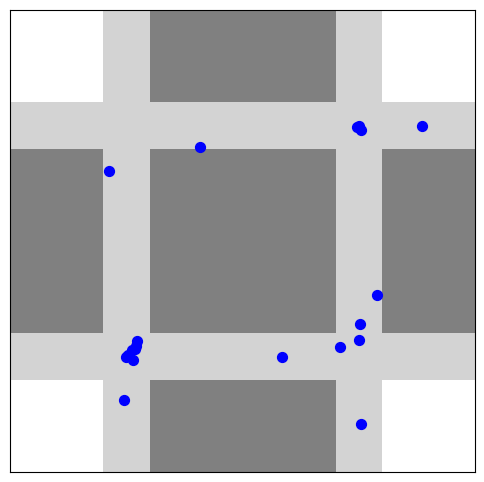

In [9]:
# Lets make a little urban intersection simulator and some pedestrians wandering around in it. This is not good code, and it's not a particularly good simulator! But I can write it kinda fast? I'll try to make a better one in the next few weeks.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
num_pedestrians = 20
seq_len = 10
prediction_horizon = 5
num_frames = 200  # Total number of frames in the simulation

# Create figure and axes
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Draw streets and sidewalks (same as before)
street_width = 4
sidewalk_width = 1
ax.add_patch(patches.Rectangle((3, 0), street_width, 10, facecolor='gray'))  # Vertical street
ax.add_patch(patches.Rectangle((0, 3), 10, street_width, facecolor='gray'))  # Horizontal street
ax.add_patch(patches.Rectangle((2, 0), sidewalk_width, 10, facecolor='lightgray'))
ax.add_patch(patches.Rectangle((7, 0), sidewalk_width, 10, facecolor='lightgray'))
ax.add_patch(patches.Rectangle((0, 2), 10, sidewalk_width, facecolor='lightgray'))
ax.add_patch(patches.Rectangle((0, 7), 10, sidewalk_width, facecolor='lightgray'))

# Remove axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Initialize pedestrian positions and destinations on sidewalks
def init_pedestrians(num):
    positions = []
    destinations = []
    while len(positions) < num:
        x_start, y_start = random_sidewalk_position()
        x_dest, y_dest = random_sidewalk_position()
        if (x_start, y_start) != (x_dest, y_dest):
            positions.append([x_start, y_start])
            destinations.append([x_dest, y_dest])
    return np.array(positions), np.array(destinations)

# Function to get a random position on the sidewalk
def random_sidewalk_position():
    # Decide whether to pick a vertical or horizontal sidewalk
    if np.random.rand() < 0.5:
        # Vertical sidewalk
        x = np.random.choice([2.5, 7.5])  # Center of vertical sidewalks
        y = np.random.uniform(0, 10)
    else:
        # Horizontal sidewalk
        x = np.random.uniform(0, 10)
        y = np.random.choice([2.5, 7.5])  # Center of horizontal sidewalks
    return x, y

# Function to check if position is on sidewalk
def is_on_sidewalk(x, y):
    on_vertical_sidewalk = (2 <= x <= 3 or 7 <= x <= 8) and (0 <= y <= 10)
    on_horizontal_sidewalk = (0 <= x <= 10) and (2 <= y <= 3 or 7 <= y <= 8)
    return on_vertical_sidewalk or on_horizontal_sidewalk

# Function to adjust position to the nearest point on the sidewalk
def adjust_to_sidewalk(x, y):
    # Snap x to nearest sidewalk center if off sidewalk
    if not (2 <= x <= 3 or 7 <= x <= 8):
        x = 2.5 if abs(x - 2.5) < abs(x - 7.5) else 7.5
    # Snap y to nearest sidewalk center if off sidewalk
    if not (2 <= y <= 3 or 7 <= y <= 8):
        y = 2.5 if abs(y - 2.5) < abs(y - 7.5) else 7.5
    return x, y

# Initialize positions and destinations
pedestrian_positions, pedestrian_destinations = init_pedestrians(num_pedestrians)

# Lists to store positions and destinations over time
positions_over_time = []
destinations_over_time = []

def simulate_pedestrians():
    global pedestrian_positions, pedestrian_destinations
    positions_over_time = []
    destinations_over_time = []
    
    # Create initial scatter plot with initial positions
    scat = ax.scatter(pedestrian_positions[:, 0], pedestrian_positions[:, 1], c='blue', s=50)
    
    for frame in range(num_frames):
        # Move pedestrians towards their destinations
        for i, (x, y) in enumerate(pedestrian_positions):
            dest_x, dest_y = pedestrian_destinations[i]
            dx = dest_x - x
            dy = dest_y - y
            distance = np.hypot(dx, dy)
            if distance < 0.1:
                # Reached destination, assign a new one
                x_new, y_new = random_sidewalk_position()
                pedestrian_destinations[i] = [x_new, y_new]
            else:
                # Normalize direction
                dx /= distance
                dy /= distance
                # Move a step towards destination
                step_size = 0.05
                x_new = x + dx * step_size
                y_new = y + dy * step_size
                if is_on_sidewalk(x_new, y_new):
                    pedestrian_positions[i] = [x_new, y_new]
                else:
                    # Adjust position to stay on sidewalk
                    x_adj, y_adj = adjust_to_sidewalk(x_new, y_new)
                    pedestrian_positions[i] = [x_adj, y_adj]
        # Record positions and destinations
        positions_over_time.append(pedestrian_positions.copy())
        destinations_over_time.append(pedestrian_destinations.copy())
    
    # After simulation, convert lists to arrays
    positions_over_time = np.array(positions_over_time)
    destinations_over_time = np.array(destinations_over_time)
    
    # Return the positions_over_time and the scatter plot artist
    return positions_over_time, destinations_over_time, scat

# Run the simulation to generate positions_over_time and destinations_over_time
positions_over_time, destinations_over_time, scat = simulate_pedestrians()

# Update function for animation
def update_with_trajectories(frame):
    # Update pedestrian positions
    pedestrian_positions = positions_over_time[frame]
    scat.set_offsets(pedestrian_positions)
    # Optionally, update trajectories if needed
    return [scat]

# Create the animation
ani = animation.FuncAnimation(fig, update_with_trajectories, frames=num_frames, interval=100, blit=True)

# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())

Epoch 1/100, Loss: 5.196909
Epoch 2/100, Loss: 3.262866
Epoch 3/100, Loss: 1.271183
Epoch 4/100, Loss: 1.066085
Epoch 5/100, Loss: 0.804612
Epoch 6/100, Loss: 0.833682
Epoch 7/100, Loss: 0.711675
Epoch 8/100, Loss: 0.655261
Epoch 9/100, Loss: 0.759063
Epoch 10/100, Loss: 0.516980
Epoch 11/100, Loss: 0.551878
Epoch 12/100, Loss: 0.991517
Epoch 13/100, Loss: 0.444103
Epoch 14/100, Loss: 0.590868
Epoch 15/100, Loss: 0.633784
Epoch 16/100, Loss: 0.512080
Epoch 17/100, Loss: 0.383016
Epoch 18/100, Loss: 0.436574
Epoch 19/100, Loss: 0.318830
Epoch 20/100, Loss: 0.367973
Epoch 21/100, Loss: 0.406478
Epoch 22/100, Loss: 0.450768
Epoch 23/100, Loss: 0.368849
Epoch 24/100, Loss: 0.352059
Epoch 25/100, Loss: 0.338971
Epoch 26/100, Loss: 0.337156
Epoch 27/100, Loss: 0.334563
Epoch 28/100, Loss: 0.280586
Epoch 29/100, Loss: 0.261534
Epoch 30/100, Loss: 0.261426
Epoch 31/100, Loss: 0.279639
Epoch 32/100, Loss: 0.227132
Epoch 33/100, Loss: 0.204852
Epoch 34/100, Loss: 0.203788
Epoch 35/100, Loss: 0.1

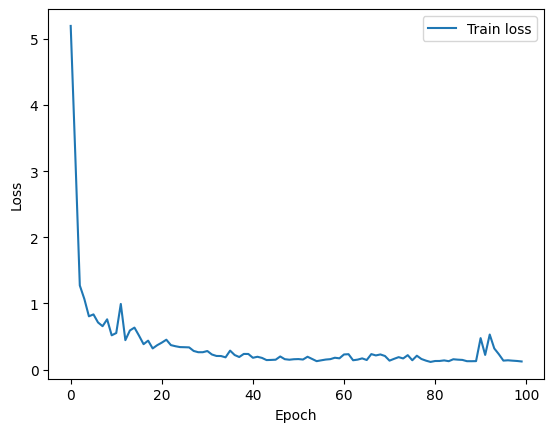

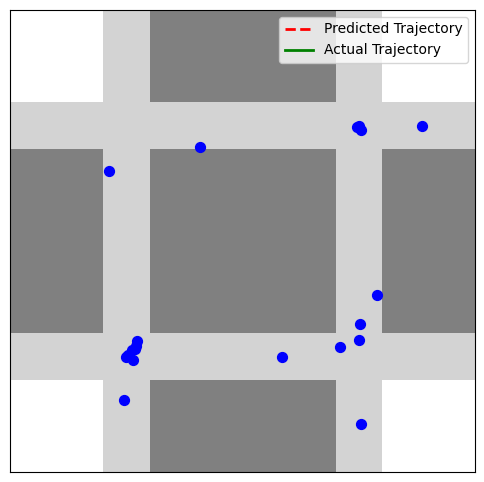

In [11]:
# okay, now we want to convert this into a dataset of all the pedestrian positions
# and then we're going to try to do prediction of the future trajectory of one of the pedestrians and visualize that
# Convert lists to arrays
positions_over_time = np.array(positions_over_time)  # Shape: (num_frames, num_pedestrians, 2)
destinations_over_time = np.array(destinations_over_time)  # Shape: (num_frames, num_pedestrians, 2)

class PedestrianDataset(Dataset):
    def __init__(self, positions, seq_len=10, prediction_horizon=5):
        self.positions = positions
        self.seq_len = seq_len
        self.prediction_horizon = prediction_horizon
        
    def __len__(self):
        return (len(self.positions) - self.seq_len - self.prediction_horizon + 1) * num_pedestrians
    
    def __getitem__(self, idx):
        # convert the index into the right frame and pedestrian index
        frame_idx = idx // num_pedestrians
        pedestrian_idx = idx % num_pedestrians
        
        # we want to turn this into a flat feature vector
        # so we want to flatten the positions so the features look like
        # (x_1, y_1, x_2, y_2, ... x_n, y_n) where the index refers to 
        # the i-th agent
        x = self.positions[frame_idx:frame_idx+self.seq_len].reshape(self.seq_len, -1)
        # we also need to know which agent we are predicting
        # so concat on a one-hot encoding of which agent we are looking at
        agent_one_hot = torch.nn.functional.one_hot(torch.tensor([pedestrian_idx]), num_classes=num_pedestrians).float()
        x = torch.cat((x, agent_one_hot.repeat(self.seq_len, 1)), dim=1)
        # Predicting the ith agent's trajectory
        y = self.positions[frame_idx+self.seq_len:frame_idx+self.seq_len+self.prediction_horizon, pedestrian_idx]
        return x, y
    
# dataset = PedestrianDataset(torch.tensor(positions_over_time, dtype=torch.float32))
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    
# Okay, now we need to make an RNN that outputs a prediction for the next x, y of the pedestrian
# Prepare the dataset and dataloader
seq_len = 10
prediction_horizon = 5
dataset = PedestrianDataset(torch.tensor(positions_over_time, dtype=torch.float32), seq_len=seq_len, prediction_horizon=prediction_horizon)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

# Define the LSTM model
class PedestrianLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=512, prediction_horizon=5):
        super(PedestrianLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Predict x and y together
        self.prediction_horizon = prediction_horizon
    
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(1, batch_size, self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Repeat the last hidden state for prediction_horizon steps
        out = out[:, -1, :].unsqueeze(1).repeat(1, self.prediction_horizon, 1)
        predictions = self.fc(out)
        return predictions

# Initialize the model, loss function, and optimizer
input_size = num_pedestrians * 3  # x and y for each pedestrian and a one-hot encoding for the pedestrian index
model = PedestrianLSTM(input_size=input_size, hidden_size=512, prediction_horizon=prediction_horizon).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
train_losses = []

# Training loop
for epoch in range(num_epochs):
    avg_train_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)  # x shape: (batch_size, seq_len, input_size), y shape: (batch_size, prediction_horizon, 2)
        predictions = model(x)  # predictions shape: (batch_size, prediction_horizon, 2)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
    avg_train_loss /= len(dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')

# Plotting the training loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualization with Predictions and Actual Trajectory
# We will use the stored positions_over_time for visualization
agent_idx = 5  # Index of the agent to predict

# Reset the figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# Draw streets and sidewalks (same as before)
ax.add_patch(patches.Rectangle((3, 0), street_width, 10, facecolor='gray'))  # Vertical street
ax.add_patch(patches.Rectangle((0, 3), 10, street_width, facecolor='gray'))  # Horizontal street
ax.add_patch(patches.Rectangle((2, 0), sidewalk_width, 10, facecolor='lightgray'))
ax.add_patch(patches.Rectangle((7, 0), sidewalk_width, 10, facecolor='lightgray'))
ax.add_patch(patches.Rectangle((0, 2), 10, sidewalk_width, facecolor='lightgray'))
ax.add_patch(patches.Rectangle((0, 7), 10, sidewalk_width, facecolor='lightgray'))

# Remove axes ticks
ax.set_xticks([])
ax.set_yticks([])

# Plot pedestrians
scat = ax.scatter([], [], c='blue', s=50)

# Create Line2D objects for the predicted and actual trajectories of pedestrian 0
predicted_line, = ax.plot([], [], 'r--', lw=2, label='Predicted Trajectory')
actual_line, = ax.plot([], [], 'g-', lw=2, label='Actual Trajectory')

# Add a legend to distinguish the lines
ax.legend(loc='upper right')

# Update function for animation with prediction overlay
def update_with_prediction(frame):
    # Update pedestrian positions
    pedestrian_positions = positions_over_time[frame]
    scat.set_offsets(pedestrian_positions)
    # Prepare data for prediction and actual trajectory
    if frame >= seq_len and frame + prediction_horizon < num_frames:
        # Prepare input for the model
        input_positions = positions_over_time[frame - seq_len:frame]  # Shape: (seq_len, num_pedestrians, 2)
        input_positions_flat = input_positions.reshape(1, seq_len, -1)  # Shape: (1, seq_len, num_pedestrians * 2)
        input_tensor = torch.tensor(input_positions_flat, dtype=torch.float32).to(device)
        agent_idx_one_hot = torch.nn.functional.one_hot(torch.tensor([agent_idx]), num_classes=num_pedestrians).float().to(input_tensor.device)
        input_tensor = torch.cat((input_tensor, agent_idx_one_hot.repeat(seq_len, 1).unsqueeze(0)), dim=-1)
        # Get the prediction from the model
        model.eval()
        with torch.no_grad():
            predicted_positions = model(input_tensor)  # Shape: (1, prediction_horizon, 2)
            predicted_positions = predicted_positions.cpu().numpy()[0]  # Shape: (prediction_horizon, 2)
        # Plot the predicted trajectory for pedestrian 0
        current_pos = pedestrian_positions[agent_idx]
        line_x_pred = [current_pos[0]] + predicted_positions[:, 0].tolist()
        line_y_pred = [current_pos[1]] + predicted_positions[:, 1].tolist()
        predicted_line.set_data(line_x_pred, line_y_pred)
        # Get the actual future trajectory of pedestrian 0
        actual_future_positions = positions_over_time[frame:frame + prediction_horizon + 1, agent_idx]  # Including current position
        actual_line.set_data(actual_future_positions[:, 0], actual_future_positions[:, 1])
    else:
        predicted_line.set_data([], [])
        actual_line.set_data([], [])
    return scat, predicted_line, actual_line

# Run the animation with prediction overlay
ani_pred = animation.FuncAnimation(fig, update_with_prediction, frames=num_frames, interval=100, blit=True)

# Display the animation with predictions and actual trajectory
from IPython.display import HTML
HTML(ani_pred.to_jshtml())
    

In [47]:
# Now lets note a few things that I think were pretty bad decisions in this training loop! First off, we're not preprocessing our features at all. 
# Lets look at the distribution of the values of our features. 
# compute the mean and std. deviation of the features
mean = torch.zeros(input_size)
std = torch.zeros(input_size)
for x, _ in dataloader:
    mean += x.mean(dim=(0, 1))
    std += x.std(dim=(0, 1))
mean /= len(dataloader)
std /= len(dataloader)
mean = mean.to(device)
std = std.to(device)
print(mean, std)

tensor([7.3305, 5.8841, 6.9733, 2.3213, 4.0019, 4.0732, 3.8297, 1.8165, 7.7257,
        2.4305, 2.7398, 7.1065, 2.7448, 2.7952, 7.1526, 2.7450, 5.1097, 7.5763,
        7.1148, 7.2444, 7.0633, 3.8298, 2.8109, 7.2622, 7.7058, 5.3316, 6.3659,
        7.4323, 2.6233, 5.6935, 7.5532, 7.1542, 7.2970, 3.9531, 3.2200, 7.7471,
        2.7159, 2.8591, 2.6352, 7.2525, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497,
        0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0497, 0.0505, 0.0505,
        0.0505, 0.0505, 0.0505, 0.0505, 0.0505, 0.0505], device='cuda:0') tensor([0.1007, 0.1823, 0.2246, 0.1295, 0.1416, 0.1015, 0.0952, 0.1232, 0.0828,
        0.1883, 0.1293, 0.2047, 0.1339, 0.1599, 0.1778, 0.1255, 0.1448, 0.0175,
        0.1603, 0.1292, 0.0964, 0.1686, 0.1727, 0.1348, 0.0624, 0.1793, 0.1443,
        0.0183, 0.0343, 0.1956, 0.1416, 0.1693, 0.0605, 0.1486, 0.2512, 0.0914,
        0.1243, 0.1765, 0.1936, 0.1294, 0.2136, 0.2136, 0.2136, 0.2136, 0.2136,
        0.2136, 0.2136, 0.2136, 0.2136, 0.2136

These are very much not centered around zero. So what we'd like to do is what's called whitening the data. For a feature, whitening the data

1. Centers the data around zero
2. Scales the data so that the variance is 1

For a feature vector x, the transformation is $$\hat{x} = \frac{x - \mu}{\sigma + \epsilon}$$ where $\mu$ is the mean of the feature, $\sigma$ is the standard deviation of the feature, and $\epsilon$ prevents division by zero.


Epoch 1/30, Loss: 2.430960
Epoch 2/30, Loss: 1.900226
Epoch 3/30, Loss: 1.186021
Epoch 4/30, Loss: 1.152957
Epoch 5/30, Loss: 0.673452
Epoch 6/30, Loss: 0.834650
Epoch 7/30, Loss: 0.776553
Epoch 8/30, Loss: 0.781303
Epoch 9/30, Loss: 0.538489
Epoch 10/30, Loss: 0.546576
Epoch 11/30, Loss: 0.645025
Epoch 12/30, Loss: 0.478772
Epoch 13/30, Loss: 0.309906
Epoch 14/30, Loss: 0.350975
Epoch 15/30, Loss: 0.357373
Epoch 16/30, Loss: 0.407511
Epoch 17/30, Loss: 0.519492
Epoch 18/30, Loss: 0.445425
Epoch 19/30, Loss: 0.377684
Epoch 20/30, Loss: 0.447439
Epoch 21/30, Loss: 0.373151
Epoch 22/30, Loss: 0.468902
Epoch 23/30, Loss: 0.366396
Epoch 24/30, Loss: 0.318750
Epoch 25/30, Loss: 0.307245
Epoch 26/30, Loss: 0.223202
Epoch 27/30, Loss: 0.278842
Epoch 28/30, Loss: 0.243520
Epoch 29/30, Loss: 0.180684
Epoch 30/30, Loss: 0.176513
Epoch 1/30, Loss: 2.584301
Epoch 2/30, Loss: 0.936027
Epoch 3/30, Loss: 0.586702
Epoch 4/30, Loss: 0.704473
Epoch 5/30, Loss: 0.534324
Epoch 6/30, Loss: 0.509739
Epoch 7

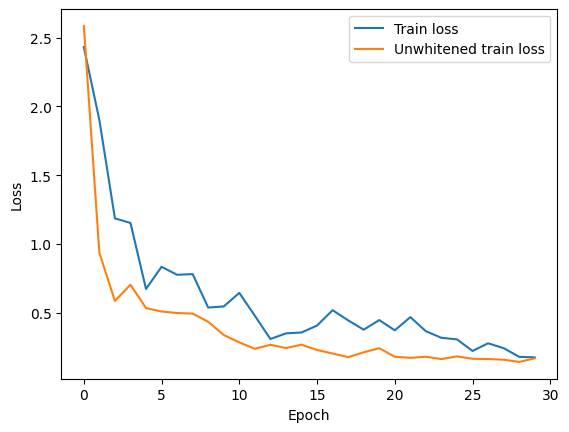

In [50]:
# So lets normalize the features before we pass things into the model
# Initialize the model, loss function, and optimizer
input_size = num_pedestrians * 3  # x and y for each pedestrian and a one-hot encoding for the pedestrian index
model = PedestrianLSTM(input_size=input_size, hidden_size=512, prediction_horizon=prediction_horizon).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
epsilon = 1e-6  # Small value to prevent division by zero
train_losses = []

# Training loop
for epoch in range(num_epochs):
    avg_train_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)  # x shape: (batch_size, seq_len, input_size), y shape: (batch_size, prediction_horizon, 2)
        x = (x - mean) / (std + epsilon)
        predictions = model(x)  # predictions shape: (batch_size, prediction_horizon, 2)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
    avg_train_loss /= len(dataloader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')
    
# and lets run this without out
unnormalized_train_loss = []
for epoch in range(num_epochs):
    avg_train_loss = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)  # x shape: (batch_size, seq_len, input_size), y shape: (batch_size, prediction_horizon, 2)
        predictions = model(x)  # predictions shape: (batch_size, prediction_horizon, 2)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
    avg_train_loss /= len(dataloader)
    unnormalized_train_loss.append(avg_train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.6f}')
    
# Plotting the training loss
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(unnormalized_train_loss, label='Unwhitened train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Second, we're predicting x and y values directly. Generally, it's better to predict an offset than it is to predict the absolute values.

60